In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
import random 
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.resnet50 import ResNet50 
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [67]:
seed_value = 42
random.seed(seed_value)  # Python
np.random.seed(seed_value)  # NumPy
tf.random.set_seed(seed_value)  # TensorFlow

In [68]:
log_dir = '/mnt/c/Users/Rahul/Desktop/Document-and-Record-Management/notebooks/experiments/'

In [69]:
train_dir = "/mnt/c/Users/Rahul/Desktop/datasets/forclassification/train/"
val_dir = "/mnt/c/Users/Rahul/Desktop/datasets/forclassification/val/"

In [70]:
batch_size = 12 
img_height, img_width = 800 , 800

In [71]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,         
    width_shift_range=0.1,     
    height_shift_range=0.1,   
    zoom_range=0.2,         
    brightness_range=[0.8, 1.2],
    shear_range=0.2,      
    horizontal_flip=False,
    vertical_flip=False
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [72]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )

Found 900 images belonging to 4 classes.


In [73]:
val_ds = train_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
    )

Found 213 images belonging to 4 classes.


In [74]:
train_ds.image_shape

(800, 800, 3)

In [75]:
num_classes = 4

In [76]:
resnet= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height,img_width,3),
                   pooling='avg',
                   weights='imagenet')
for layer in resnet.layers:
        layer.trainable=False


In [77]:
# Determine 60% of the layers
num_layers_to_freeze = int(0.60* len(resnet.layers))

# Freeze the first 45% of layers
for i, layer in enumerate(resnet.layers):
    if i < num_layers_to_freeze:
        layer.trainable = False

In [78]:
model = Sequential([ resnet,
    layers.Flatten(), 
    layers.Dense(448, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.Dense(240, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.Dense(112, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.Dropout(0.4), 
    layers.Dense(num_classes, activation='softmax')])

In [79]:
model.summary() 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 448)            │       917,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 240)            │       107,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 112)            │        26,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           452 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,868 (94.00 MB)

 Trainable params: 1,053,156 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [80]:
model.compile(optimizer=Adam(learning_rate=4e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"] 
             )

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [81]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [82]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[early_stopping,lr_scheduler] 
  )

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.6190 - loss: 1.0365 - val_accuracy: 0.9484 - val_loss: 0.3086 - learning_rate: 4.0000e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9304 - loss: 0.3488 - val_accuracy: 0.9671 - val_loss: 0.2136 - learning_rate: 4.0000e-04
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9515 - loss: 0.2597 - val_accuracy: 0.9718 - val_loss: 0.2091 - learning_rate: 4.0000e-04
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9610 - loss: 0.2157 - val_accuracy: 0.9390 - val_loss: 0.2720 - learning_rate: 4.0000e-04
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9711 - loss: 0.2068 - val_accuracy: 0.9249 - val_loss: 0.3749 - learning_rate: 4.0000e-04
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9857 - loss: 0.1668 - val_accuracy: 0.9718 - val_loss: 0.2104 - learning_rate: 2.0000e-04
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9875 - loss

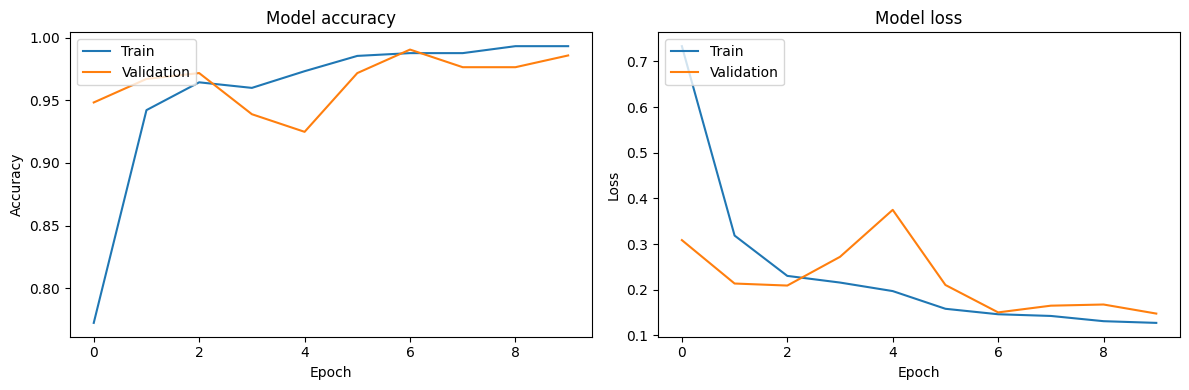

In [83]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [85]:
model.save("goodmodel.h5")